In [14]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.4 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install --upgrade xgboost


Note: you may need to restart the kernel to use updated packages.


Stage 1 - Google Spend | R²: 0.972, RMSE: 160, MAE: 128, MAPE: 1.5%


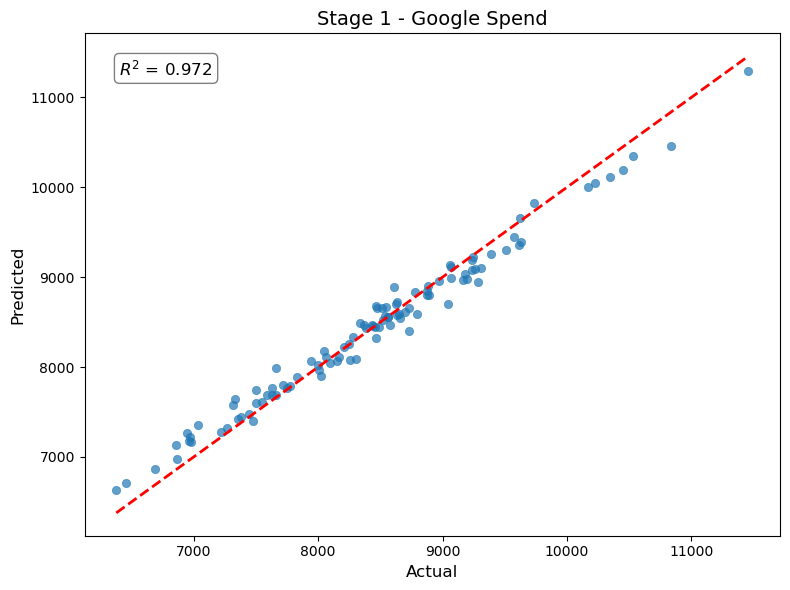

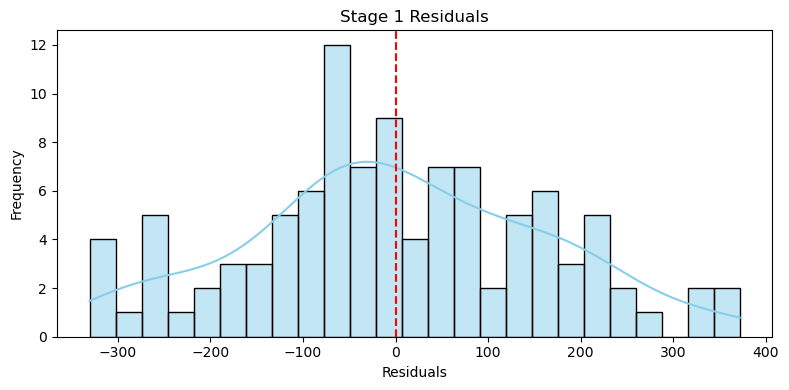

Stage 2 - Revenue | R²: 0.994, RMSE: 1039, MAE: 817, MAPE: 1.2%


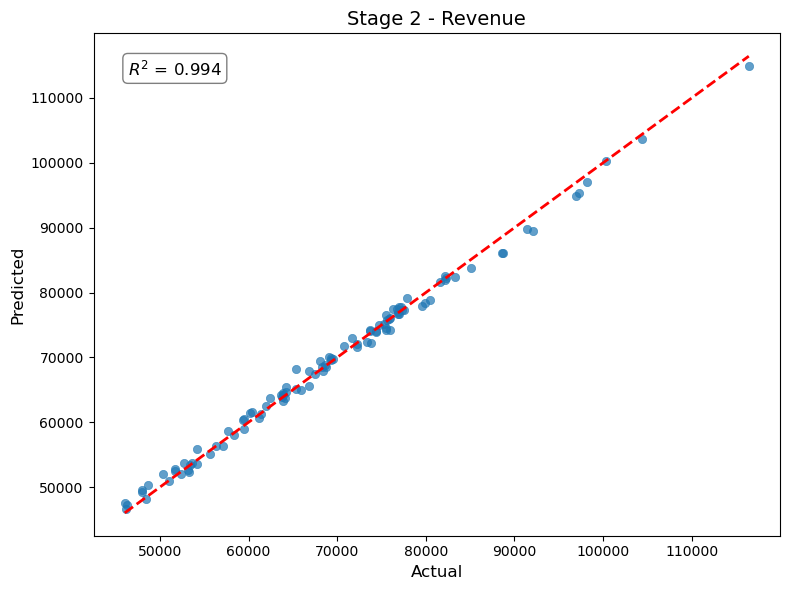

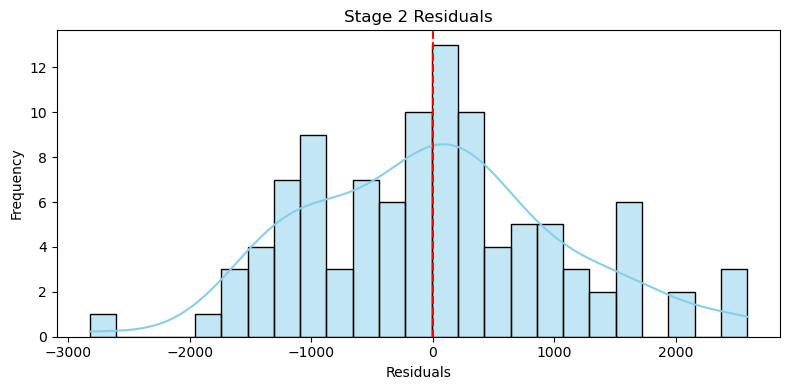


Cross-Validation Results:
R2_mean: 0.797
R2_std: 0.178
RMSE_mean: 4806.897
RMSE_std: 2247.399
MAE_mean: 3844.632
MAE_std: 1752.219
MAPE_mean: 5.540
MAPE_std: 2.430


In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# MMM Pipeline with XGBoost + Enhanced Visualization
# -------------------------------
class MMMPipelineXGB:
    def __init__(self):
        self.stage1_params = {
            'objective': 'reg:squarederror',
            'learning_rate': 0.1,
            'max_depth': 3,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'seed': 42
        }
        self.stage2_params = self.stage1_params.copy()
        self.stage1_num_boost_round = 200
        self.stage2_num_boost_round = 200
        self.scaler_stage1 = StandardScaler()
        self.scaler_stage2 = StandardScaler()

    # -------------------------------
    # Preprocessing
    # -------------------------------
    def preprocess(self, df):
        df = df.copy()
        for col in ['facebook_spend', 'tiktok_spend', 'snapchat_spend']:
            if col in df.columns:
                df[f'{col}_log'] = np.log1p(df[col].fillna(0))
        return df

    # -------------------------------
    # Stage 1: Predict Google Spend
    # -------------------------------
    def train_stage1(self, df):
        X = df[[f'{col}_log' for col in ['facebook_spend', 'tiktok_spend', 'snapchat_spend']]].values
        y = df['google_spend'].values
        X_scaled = self.scaler_stage1.fit_transform(X)
        dtrain = xgb.DMatrix(X_scaled, label=y)
        self.stage1_model = xgb.train(
            self.stage1_params,
            dtrain,
            num_boost_round=self.stage1_num_boost_round,
            evals=[(dtrain, 'train')],
            early_stopping_rounds=10,
            verbose_eval=False
        )
        pred = self.stage1_model.predict(dtrain)
        return pred, self.compute_metrics(y, pred)

    # -------------------------------
    # Stage 2: Predict Revenue
    # -------------------------------
    def train_stage2(self, df, google_pred):
        base_features = ['email_sends', 'sms_sends', 'avg_price', 'followers', 'promotions']
        X = df[base_features].values
        X = np.column_stack([X, google_pred])
        y = df['revenue'].values
        X_scaled = self.scaler_stage2.fit_transform(X)
        dtrain = xgb.DMatrix(X_scaled, label=y)
        self.stage2_model = xgb.train(
            self.stage2_params,
            dtrain,
            num_boost_round=self.stage2_num_boost_round,
            evals=[(dtrain, 'train')],
            early_stopping_rounds=10,
            verbose_eval=False
        )
        pred = self.stage2_model.predict(dtrain)
        return pred, self.compute_metrics(y, pred)

    # -------------------------------
    # Metrics Calculation
    # -------------------------------
    @staticmethod
    def compute_metrics(y_true, y_pred):
        r2 = r2_score(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        mape = np.mean(np.abs((y_true - y_pred)/y_true)) * 100
        return r2, rmse, mae, mape

    # -------------------------------
    # Time Series Cross Validation
    # -------------------------------
    def time_series_cv(self, df, n_splits=5):
        tscv = TimeSeriesSplit(n_splits=n_splits)
        r2_scores, rmse_scores, mae_scores, mape_scores = [], [], [], []

        for train_idx, val_idx in tscv.split(df):
            train_df, val_df = df.iloc[train_idx], df.iloc[val_idx]

            # Stage 1
            google_pred_train, _ = self.train_stage1(train_df)
            X_val_stage1 = val_df[[f'{col}_log' for col in ['facebook_spend', 'tiktok_spend', 'snapchat_spend']]].values
            X_val_stage1_scaled = self.scaler_stage1.transform(X_val_stage1)
            dval_stage1 = xgb.DMatrix(X_val_stage1_scaled)
            google_pred_val = self.stage1_model.predict(dval_stage1)

            # Stage 2
            base_features = ['email_sends', 'sms_sends', 'avg_price', 'followers', 'promotions']
            X_val_stage2 = val_df[base_features].values
            X_val_stage2 = np.column_stack([X_val_stage2, google_pred_val])
            X_val_stage2_scaled = self.scaler_stage2.transform(X_val_stage2)
            dval_stage2 = xgb.DMatrix(X_val_stage2_scaled)
            y_val = val_df['revenue'].values
            revenue_pred_val = self.stage2_model.predict(dval_stage2)

            r2, rmse, mae, mape = self.compute_metrics(y_val, revenue_pred_val)
            r2_scores.append(r2)
            rmse_scores.append(rmse)
            mae_scores.append(mae)
            mape_scores.append(mape)

        return {
            "R2_mean": np.mean(r2_scores),
            "R2_std": np.std(r2_scores),
            "RMSE_mean": np.mean(rmse_scores),
            "RMSE_std": np.std(rmse_scores),
            "MAE_mean": np.mean(mae_scores),
            "MAE_std": np.std(mae_scores),
            "MAPE_mean": np.mean(mape_scores),
            "MAPE_std": np.std(mape_scores),
        }

    # -------------------------------
    # Enhanced Visualization
    # -------------------------------
    @staticmethod
    def plot_actual_vs_predicted(y_true, y_pred, title="Actual vs Predicted"):
        plt.figure(figsize=(8,6))
        sns.scatterplot(x=y_true, y=y_pred, alpha=0.7, edgecolor=None)
        plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
        plt.xlabel("Actual", fontsize=12)
        plt.ylabel("Predicted", fontsize=12)
        plt.title(title, fontsize=14)
        r2 = r2_score(y_true, y_pred)
        plt.text(0.05, 0.95, f"$R^2$ = {r2:.3f}", transform=plt.gca().transAxes,
                 fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.5))
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_residuals(y_true, y_pred, title="Residuals"):
        residuals = y_true - y_pred
        plt.figure(figsize=(8,4))
        sns.histplot(residuals, kde=True, color='skyblue', bins=25)
        plt.axvline(0, color='red', linestyle='--')
        plt.xlabel("Residuals")
        plt.ylabel("Frequency")
        plt.title(title)
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_time_series(df, y_true, y_pred, date_col='date', title='Revenue Over Time'):
        if date_col not in df.columns:
            return
        plt.figure(figsize=(12,5))
        plt.plot(df[date_col], y_true, label='Actual', marker='o')
        plt.plot(df[date_col], y_pred, label='Predicted', marker='x')
        plt.xticks(rotation=45)
        plt.xlabel("Date")
        plt.ylabel("Revenue")
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_mape_heatmap(df, y_true, y_pred, date_col='date'):
        if date_col not in df.columns:
            return
        df_temp = df.copy()
        df_temp['mape'] = np.abs((y_true - y_pred)/y_true) * 100
        df_temp = df_temp.pivot_table(index=date_col, values='mape')
        plt.figure(figsize=(12,3))
        sns.heatmap(df_temp.T, annot=True, fmt=".1f", cmap="Reds")
        plt.title("MAPE Heatmap")
        plt.tight_layout()
        plt.show()

    # -------------------------------
    # Run Full Pipeline
    # -------------------------------
    def run_pipeline(self, df):
        df_processed = self.preprocess(df)

        # Stage 1
        google_pred, (r2_s1, rmse_s1, mae_s1, mape_s1) = self.train_stage1(df_processed)
        print(f"Stage 1 - Google Spend | R²: {r2_s1:.3f}, RMSE: {rmse_s1:.0f}, MAE: {mae_s1:.0f}, MAPE: {mape_s1:.1f}%")
        self.plot_actual_vs_predicted(df_processed['google_spend'], google_pred, "Stage 1 - Google Spend")
        self.plot_residuals(df_processed['google_spend'], google_pred, "Stage 1 Residuals")

        # Stage 2
        revenue_pred, (r2_s2, rmse_s2, mae_s2, mape_s2) = self.train_stage2(df_processed, google_pred)
        print(f"Stage 2 - Revenue | R²: {r2_s2:.3f}, RMSE: {rmse_s2:.0f}, MAE: {mae_s2:.0f}, MAPE: {mape_s2:.1f}%")
        self.plot_actual_vs_predicted(df_processed['revenue'], revenue_pred, "Stage 2 - Revenue")
        self.plot_residuals(df_processed['revenue'], revenue_pred, "Stage 2 Residuals")
        self.plot_time_series(df_processed, df_processed['revenue'], revenue_pred, date_col='date', title='Revenue Over Time')
        self.plot_mape_heatmap(df_processed, df_processed['revenue'], revenue_pred, date_col='date')

        # Cross-validation
        cv_results = self.time_series_cv(df_processed)
        print("\nCross-Validation Results:")
        for k, v in cv_results.items():
            print(f"{k}: {v:.3f}")


# -------------------------------
# Example Run with CSV
# -------------------------------
if __name__ == "__main__":
    csv_file = 'MMM Weekly.csv'  # Replace with your CSV
    df = pd.read_csv(csv_file)
    df.fillna(0, inplace=True)

    mmm = MMMPipelineXGB()
    mmm.run_pipeline(df)
